In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve, auc

from fractions import Fraction

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/Khazar-university-ml/ml-project/

/content/drive/MyDrive/Khazar-university-ml/ml-project


In [4]:
df = pd.read_csv('data/heart_disease_uci.csv',index_col = 0)
df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
id,,,,,,,,,,,,,,,
1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


# EDA

In [5]:
df.isnull().sum() / df.shape[0] * 100

age          0.000000
sex          0.000000
dataset      0.000000
cp           0.000000
trestbps     6.413043
chol         3.260870
fbs          9.782609
restecg      0.217391
thalch       5.978261
exang        5.978261
oldpeak      6.739130
slope       33.586957
ca          66.413043
thal        52.826087
num          0.000000
dtype: float64

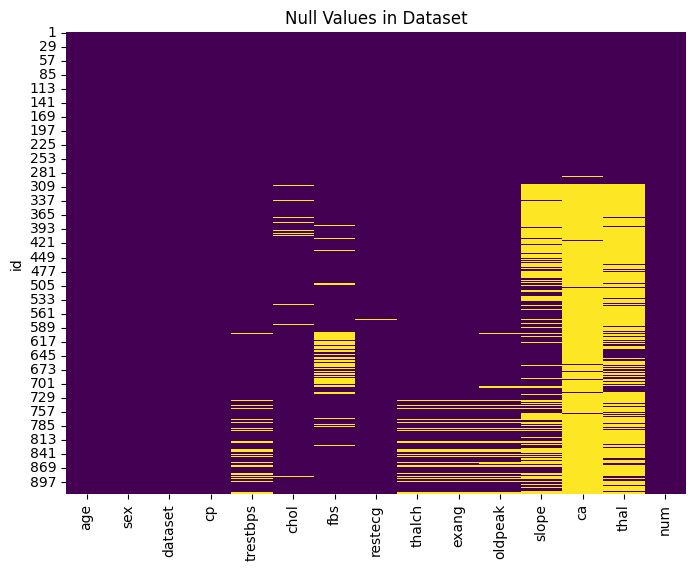

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# Add a title
plt.title('Null Values in Dataset')

# Show the plot
plt.show()

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,920.0,53.510870,9.424685,28.0,47.0,54.0,60.0,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.0,130.0,140.0,200.0
chol,890.0,199.130337,110.780810,0.0,175.0,223.0,268.0,603.0
thalch,865.0,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.0,0.5,1.5,6.2
ca,309.0,0.676375,0.935653,0.0,0.0,0.0,1.0,3.0
num,920.0,0.995652,1.142693,0.0,0.0,1.0,2.0,4.0


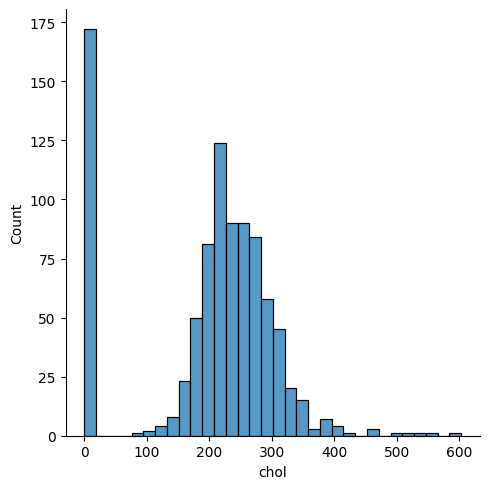

In [ ]:
sns.displot(df['chol'])
plt.show()

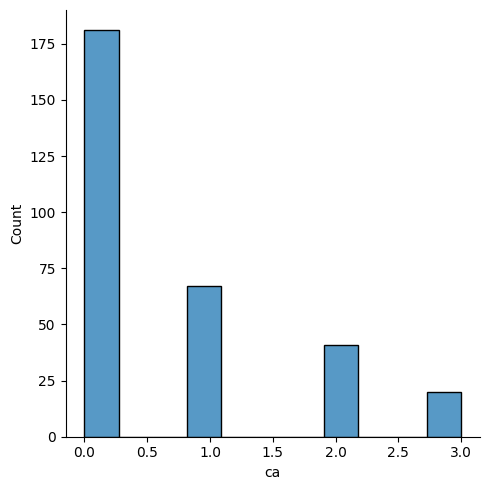

In [ ]:
sns.displot(df['ca'])
plt.show()

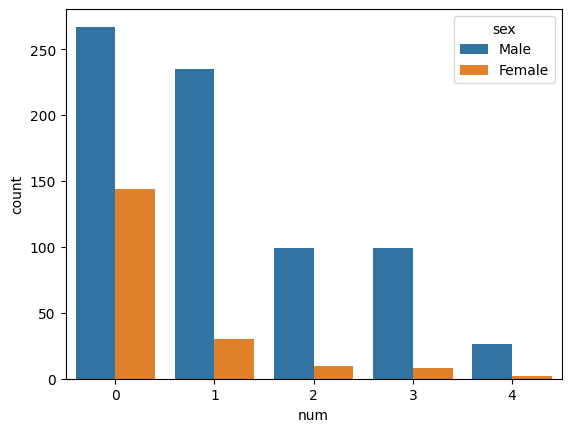

In [ ]:
sns.countplot(x=df['num'],hue=df['sex'])
plt.show()


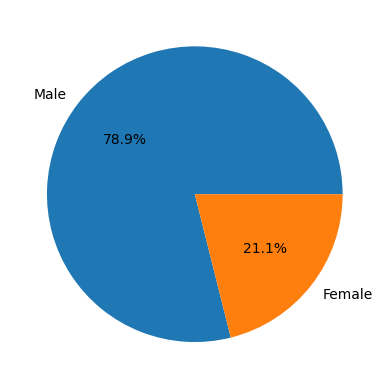

In [ ]:
fig, ax = plt.subplots()
ax.pie(df['sex'].value_counts().values, labels=df['sex'].value_counts().index,autopct='%1.1f%%')
plt.show()

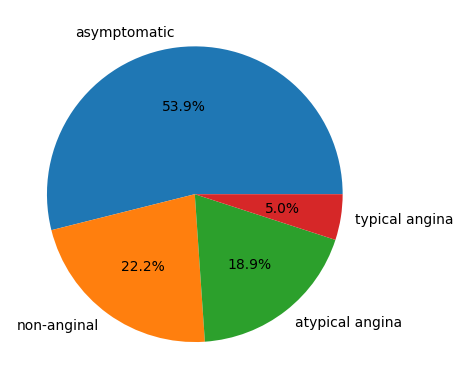

In [ ]:
fig, ax = plt.subplots()
ax.pie(df['cp'].value_counts().values, labels=df['cp'].value_counts().index,autopct='%1.1f%%')
plt.show()

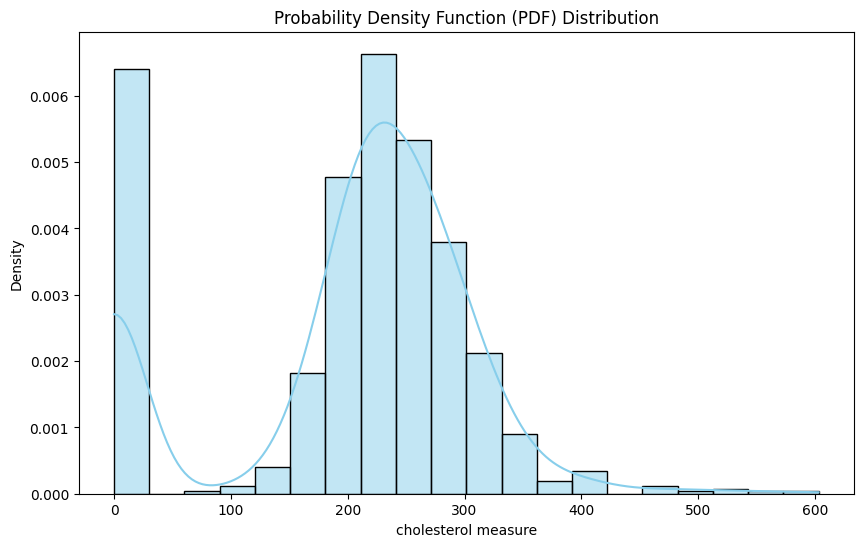

In [ ]:
data = df['chol'].values
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=20, color='skyblue', stat='density')
plt.title('Probability Density Function (PDF) Distribution')
plt.xlabel('cholesterol measure')
plt.ylabel('Density')
plt.show()

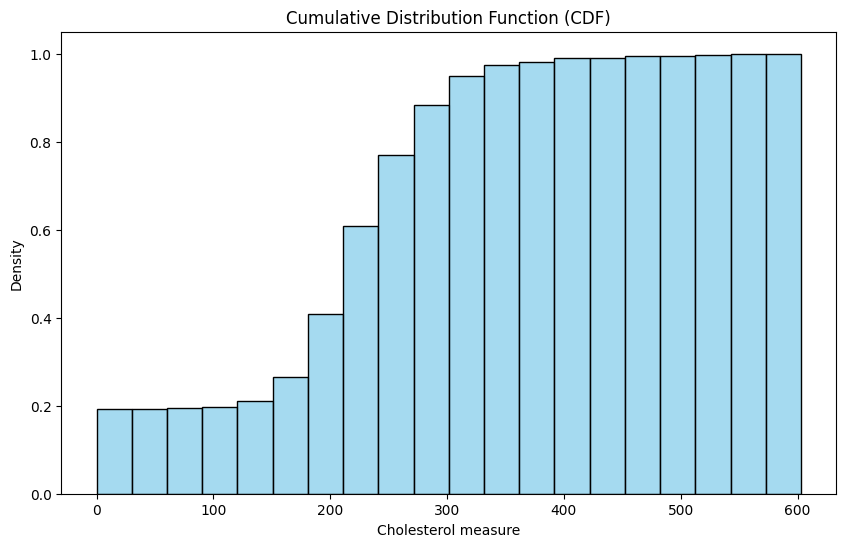

In [ ]:
data = df['chol'].values

plt.figure(figsize=(10, 6))
sns.histplot(data, cumulative=True, bins=20, color='skyblue', stat='density')
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Cholesterol measure')
plt.ylabel('Density')
plt.show()

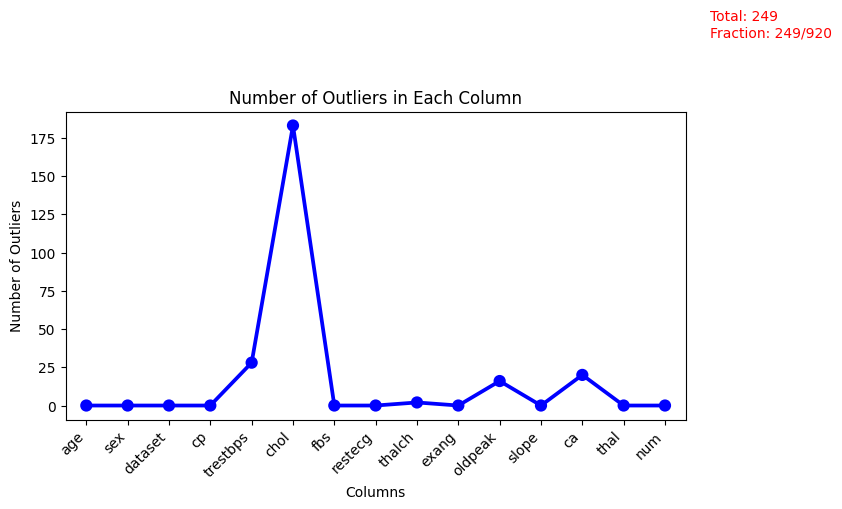

In [ ]:
def count_outliers(column):
    if pd.api.types.is_numeric_dtype(column):
        q1 = column.quantile(0.25)
        q3 = column.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (column < lower_bound) | (column > upper_bound)
        return outliers.sum()
    else:
        return 0

def count_outliers_for_each_column(dataframe):
    return dataframe.apply(count_outliers)

outlier_counts = count_outliers_for_each_column(df)

total_outliers = outlier_counts.sum()

total_rows = len(df)
fraction_outliers = Fraction(total_outliers, total_rows)

plt.figure(figsize=(8, 4))
sns.pointplot(x=outlier_counts.index, y=outlier_counts.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers in Each Column')

plt.text(len(outlier_counts) + 0.1, total_outliers, f'Total: {total_outliers}\nFraction: {fraction_outliers}', ha='left', va='center', color='red')

plt.show()

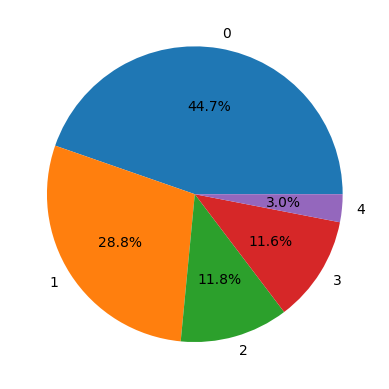

In [ ]:
fig, ax = plt.subplots()
ax.pie(df['num'].value_counts().values, labels=df['num'].value_counts().index,autopct='%1.1f%%')
plt.show()

#Preprocessing

In [8]:
class ColumnDropper(BaseEstimator,TransformerMixin):
  def __init__(self,dropping_cols):
    self.dropping_cols = dropping_cols

  def fit(self,X,y=None):
    return self

  def transform(self,X):
    return X.drop(self.dropping_cols,axis=1)

In [9]:
class RowDropper(BaseEstimator,TransformerMixin):

  def fit(self,X,y=None):
    return self

  def transform(self,X):
    return X.dropna()

In [10]:
class FeatureEncoder(BaseEstimator,TransformerMixin):

  def __init__(self,columns_to_encode):
    self.columns_to_encode = columns_to_encode

  def fit(self,X,y=None):
    return self

  def transform(self,X):

    ohe = OneHotEncoder(drop='first')

    ohe.fit(X[self.columns_to_encode])

    matrix = ohe.transform(X[self.columns_to_encode]).toarray()

    matrix_df = pd.DataFrame(matrix,columns=ohe.get_feature_names_out())

    df = X.drop(self.columns_to_encode,axis=1)

    df.index = range(df.shape[0])
    matrix_df.index = range(matrix_df.shape[0])

    final_df = pd.concat([df,matrix_df],axis = 1)

    return final_df

In [11]:
class OutlierHandler(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols = cols

  def fit(self,X,y=None):
    return self

  def transform(self,X):
    data = X
    for i in self.cols:
      data = self.remove_outlier(data,i)
    X=data
    return X
  def remove_outlier(self,data, col):


    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)

    iqr = q3-q1

    k = 1.5

    lower = q1 - k*iqr
    upper = q3 + k*iqr



    new_df = data[(data[col]<=upper)&(data[col]>=lower)]

    return new_df

In [12]:
class LogTransformator(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols = cols
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    X[self.cols] = np.log1p(X[self.cols])
    return X

In [13]:
class Scaler(BaseEstimator,TransformerMixin):
  def __init__(self, cols_to_scaler):
    self.cols_to_scaler = cols_to_scaler
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    scaler = scaler = MinMaxScaler()

    X[self.cols_to_scaler] = scaler.fit_transform(X[self.cols_to_scaler])

    return X


In [14]:
class TargetHandler(BaseEstimator,TransformerMixin):

  def __init__(self,col):
    self.col = col

  def fit(self,X,y=None):
    return self
  def transform(self,X):
    X['target'] = X[self.col].apply(lambda x: x if x == 0 else 1)
    X = X.drop([self.col],axis = 1)
    return X


In [15]:
def ConfusionMatrix(conf_matrix):
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

In [16]:
missing_percentage = df.isnull().sum() / df.shape[0] * 100

columns_to_drop = missing_percentage[missing_percentage > 30].index


In [17]:
cat_cols = df.select_dtypes(include=['O']).columns
columns_to_encode = []
for i in list(cat_cols):
  if i not in columns_to_drop:
    columns_to_encode.append(i)

In [18]:
num_cols = df._get_numeric_data().columns
outlier_cols = []
for i in list(num_cols):
  if i not in columns_to_drop and i != 'num':
    outlier_cols.append(i)

In [19]:
num_cols = df._get_numeric_data().columns
log_cols = []
for i in list(num_cols):
  if i not in columns_to_drop and i != 'num':
    log_cols.append(i)

In [20]:
pipe = Pipeline([
    ('column_dropper',ColumnDropper(columns_to_drop)),
    ('row_dropper',RowDropper()),
    ('encoding', FeatureEncoder(columns_to_encode)),
    ('outlier_handler',OutlierHandler(outlier_cols)),
    ('log_transformation',LogTransformator(log_cols)),
    ('scaling', Scaler(log_cols)),
    ('target', TargetHandler('num'))
])

In [21]:
processed_data = pipe.fit_transform(df)

In [22]:
processed_data.head()

,age,trestbps,chol,thalch,oldpeak,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,target
0,0.800057,0.740492,0.652576,0.714506,0.782358,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
1,0.861331,0.901063,0.811147,0.400063,0.600430,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0.861331,0.432124,0.639185,0.570039,0.839375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.273183,0.562499,0.707047,0.925942,0.985598,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,0.374337,0.562499,0.549812,0.845723,0.573680,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


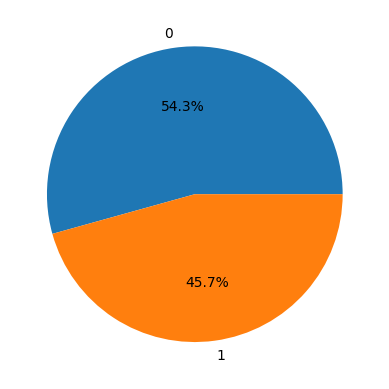

In [ ]:
fig, ax = plt.subplots()
ax.pie(processed_data['target'].value_counts().values, labels=processed_data['target'].value_counts().index,autopct='%1.1f%%')
plt.show()

In [ ]:
processed_data.shape

(613, 17)

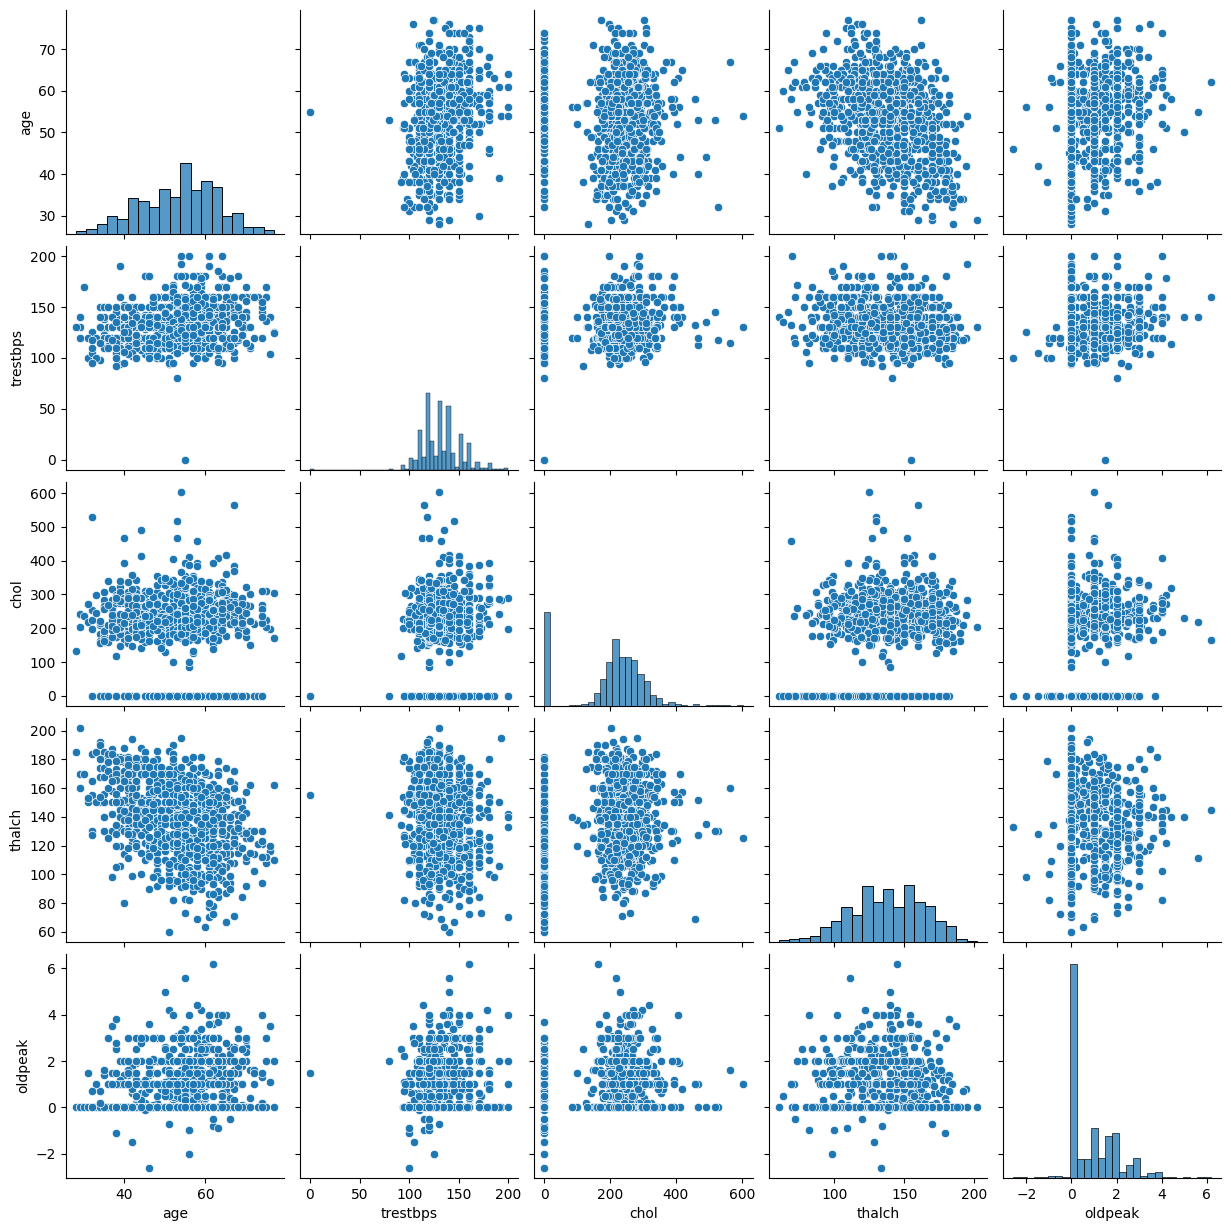

In [ ]:
sns.pairplot(df[outlier_cols])

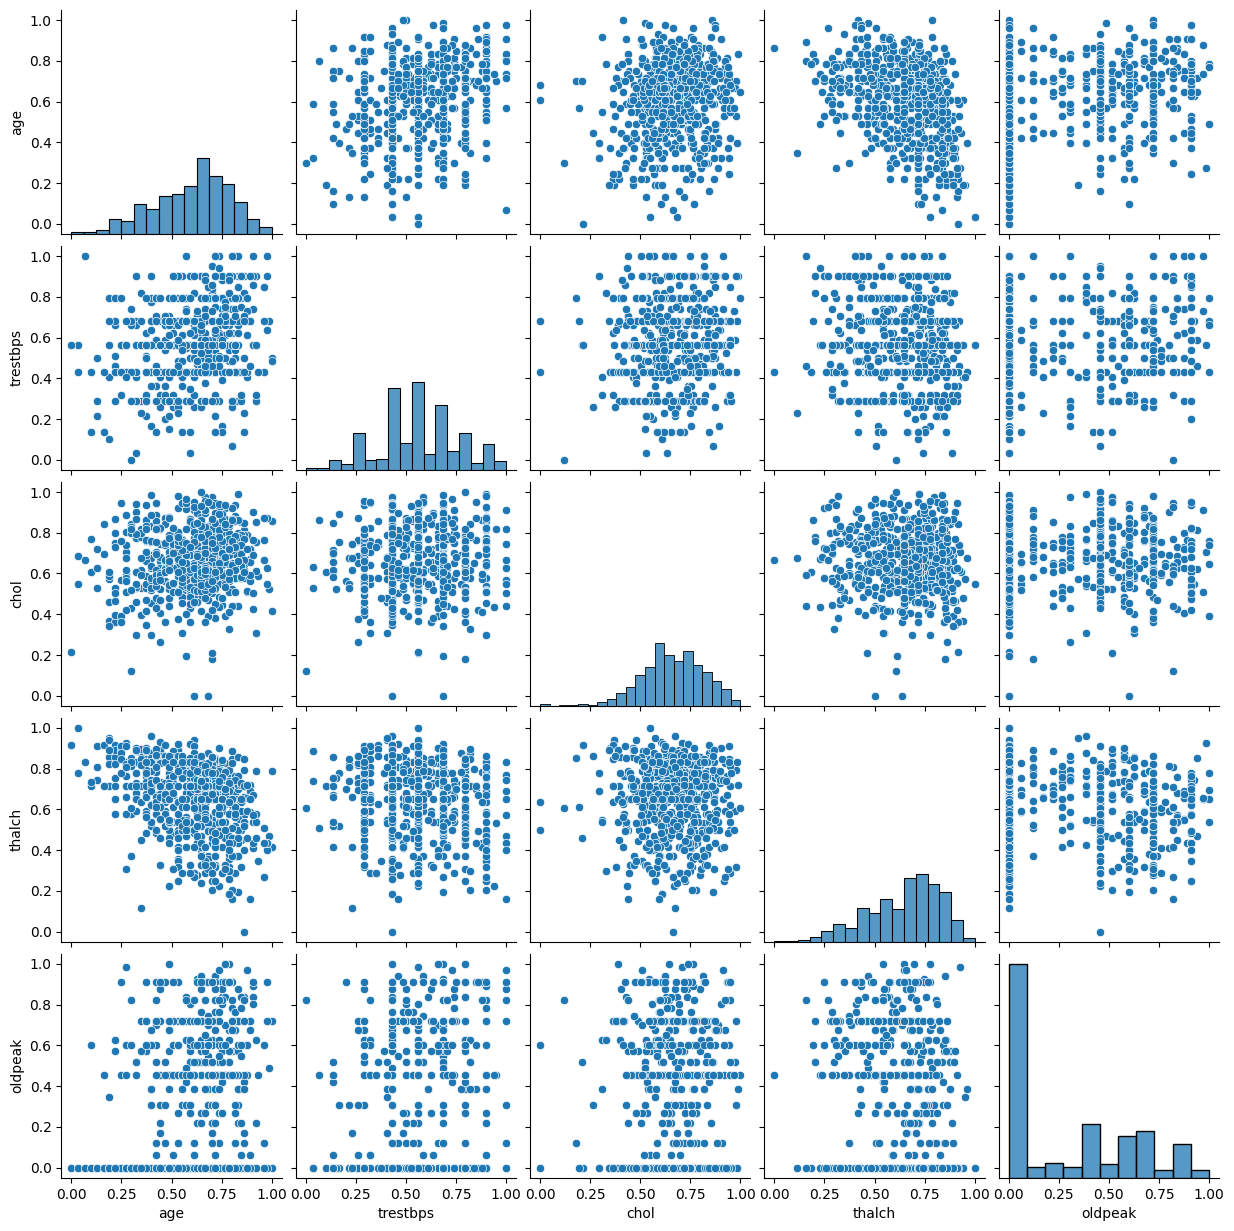

In [ ]:
sns.pairplot(processed_data[outlier_cols])

In [ ]:
train, test = train_test_split(df, test_size=0.25, shuffle=df['num'],random_state=2023)

In [ ]:
preprocessed_train = pipe.fit_transform(train)
X_train, y_train = preprocessed_train.drop('target',axis = 1), preprocessed_train['target']

In [ ]:
prepro_test = pipe.fit_transform(test)

In [ ]:
X_test, y_test = prepro_test.drop('target',axis = 1), prepro_test['target']

# Modelling

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
pred_train = lr.predict(X_train)
print(classification_report(pred_train,y_train))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       252
           1       0.77      0.81      0.79       202

    accuracy                           0.80       454
   macro avg       0.80      0.80      0.80       454
weighted avg       0.81      0.80      0.80       454



In [ ]:
scores_logistic = cross_val_score(LogisticRegression(),X_train,y_train,cv=10)
scores_logistic.mean()

0.7820289855072463

In [ ]:
test_pred = lr.predict(X_test)

In [ ]:
print(classification_report(test_pred,prepro_test['target']))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        94
           1       0.79      0.82      0.81        66

    accuracy                           0.84       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.84      0.84      0.84       160



## Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

In [ ]:
train_pred = nb.predict(X_train)

In [ ]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       241
           1       0.78      0.73      0.75       213

    accuracy                           0.78       454
   macro avg       0.78      0.77      0.78       454
weighted avg       0.78      0.78      0.78       454



In [ ]:
scores_nb = cross_val_score(GaussianNB(), X_train,y_train,cv=10)
scores_nb.mean()

0.7841545893719807

In [ ]:
test_pred = nb.predict(X_test)

In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90        93
           1       0.85      0.87      0.86        67

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



#Selected Algorithm: Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

In [ ]:
prediction = nb.predict(X_test)
accuracy_score(prediction,y_test)

0.88125

In [ ]:
precision_score(prediction,y_test)

0.8529411764705882

In [ ]:
recall_score(prediction,y_test)

0.8656716417910447

In [ ]:
print(classification_report(nb.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       256
           1       0.73      0.78      0.75       198

    accuracy                           0.78       454
   macro avg       0.77      0.78      0.78       454
weighted avg       0.78      0.78      0.78       454



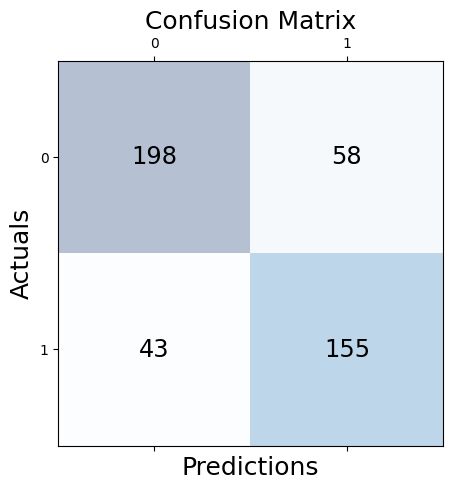

In [ ]:
ConfusionMatrix(confusion_matrix(nb.predict(X_train),y_train))

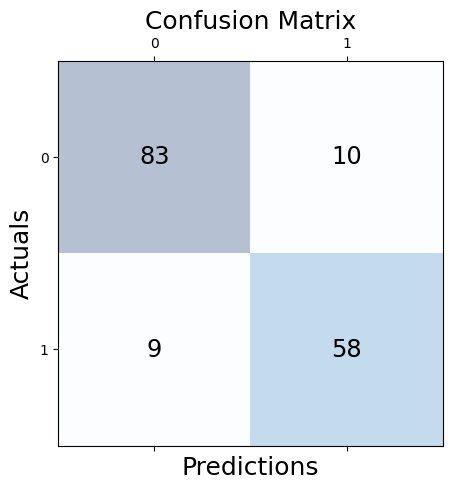

In [ ]:
ConfusionMatrix(confusion_matrix(prediction,y_test))

# Hyperparameter Tuning

## For Logistic regression

In [ ]:
model1 = LogisticRegression()

hyperparameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}
model1_tuning = GridSearchCV(estimator= model1,param_grid= hyperparameters,verbose = 5)
model1_tuning.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END C=100, penalty=l2, solver=newton-cg;, score=0.813 total time=   0.0s
[CV 2/5] END C=100, penalty=l2, solver=newton-cg;, score=0.758 total time=   0.0s
[CV 3/5] END C=100, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.0s
[CV 4/5] END C=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.0s
[CV 5/5] END C=100, penalty=l2, solver=newton-cg;, score=0.789 total time=   0.0s
[CV 1/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.813 total time=   0.0s
[CV 2/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.758 total time=   0.0s
[CV 3/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.835 total time=   0.0s
[CV 4/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.802 total time=   0.1s
[CV 5/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.789 total time=   0.0s
[CV 1/5] END C=100, penalty=l2, solver=liblinear;, score=0.813 total time=   0.0s
[CV 2/5] END C=100, penalty=l2, solver=lib

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=5)

In [ ]:
model1_tuning.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
tuning_logistic_resgression = LogisticRegression(C = model1_tuning.best_params_['C'],
                                                 penalty = model1_tuning.best_params_['penalty'],
                                                 solver = model1_tuning.best_params_['solver'])
tuning_logistic_resgression.fit(X_train,y_train)

LogisticRegression(C=100, solver='newton-cg')

In [ ]:
print('Performance of model on Train set')
pred_train = tuning_logistic_resgression.predict(X_train)
print(classification_report(y_train, pred_train))

print('Performance of model on Test set')
pred_test = tuning_logistic_resgression.predict(X_test)
print(classification_report(y_test,pred_test))

Performance of model on Train set
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       241
           1       0.82      0.78      0.80       213

    accuracy                           0.81       454
   macro avg       0.82      0.81      0.81       454
weighted avg       0.82      0.81      0.81       454

Performance of model on Test set
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        92
           1       0.83      0.81      0.82        68

    accuracy                           0.85       160
   macro avg       0.85      0.84      0.85       160
weighted avg       0.85      0.85      0.85       160



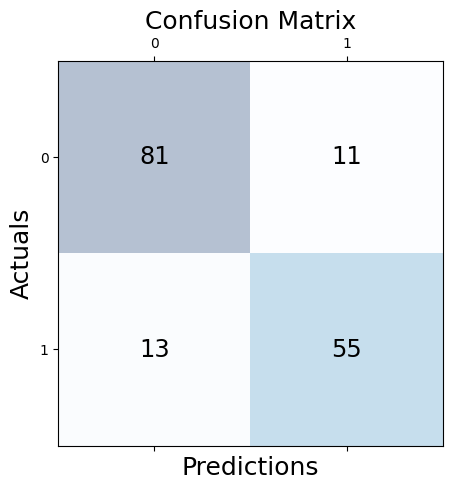

In [ ]:
ConfusionMatrix(confusion_matrix(y_test,pred_test))

## For Naive Bayes

In [ ]:
model2 = GaussianNB()

hyperparameters = {
    'var_smoothing':np.logspace(0,-9, num=100)

}
model2_tuning = GridSearchCV(estimator= model2,param_grid= hyperparameters,verbose=5)
model2_tuning.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.780 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.758 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.758 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.824 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.744 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.791 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.747 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.758 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.824 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.756 total time=   0.0s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.791 total time=   0.0s
[CV 2/5] END ...var_smoothing=0.65793322465756

GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3101297...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=5)

In [ ]:
model2_tuning.best_params_

{'var_smoothing': 0.01519911082952933}

In [ ]:
nb_tuning = GaussianNB(var_smoothing = model2_tuning.best_params_['var_smoothing'])
nb_tuning.fit(X_train,y_train)

GaussianNB(var_smoothing=0.01519911082952933)

In [ ]:
print('Performance of model on Train set')
pred_train = nb_tuning.predict(X_train)
print(classification_report(y_train, pred_train))

print('Performance of model on Test set')
pred_test = nb_tuning.predict(X_test)
print(classification_report(y_test,pred_test))

Performance of model on Train set
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       241
           1       0.79      0.73      0.76       213

    accuracy                           0.78       454
   macro avg       0.78      0.78      0.78       454
weighted avg       0.78      0.78      0.78       454

Performance of model on Test set
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        92
           1       0.87      0.85      0.86        68

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



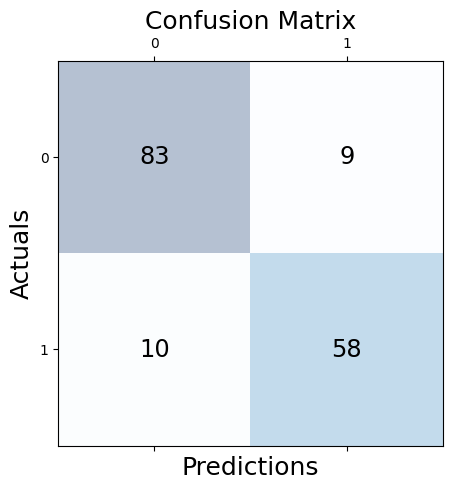

In [ ]:
ConfusionMatrix(confusion_matrix(y_test,pred_test))

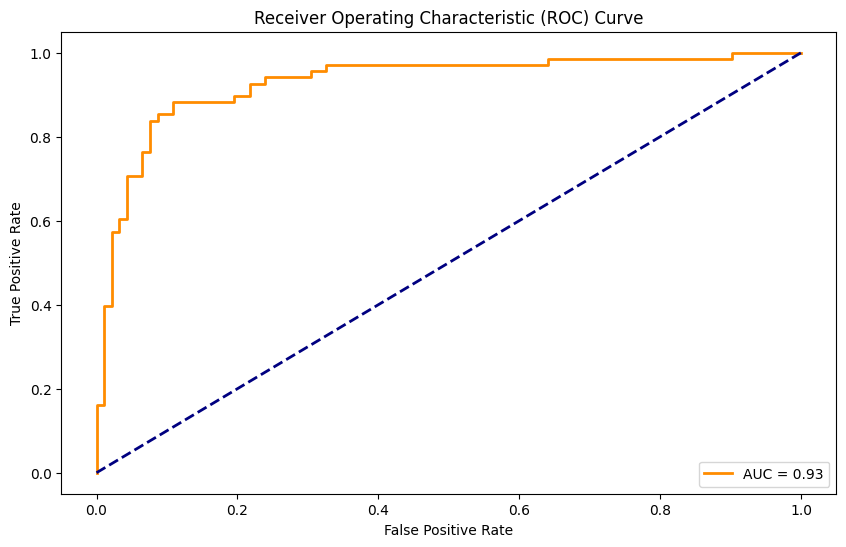

In [ ]:
y_pred_prob = nb_tuning.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()